# Example for analysis of NanoAOD samples

In this example we don't need any pre-processing of NanoAOD samples and can still use several tools of the tW_scattering repository.

- Get the proper normalization for samples
- Categorize different samples into process categories
- Use coffea processors for the map-reduce step
- Make "nice" histograms


In [1]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.charge_flip_check import charge_flip_check
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

In [62]:
from processor.default_accumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

from processor.meta_processor import get_sample_meta

overwrite = True
local = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'charge_flip_check'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples()

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['DY', 'TTZ', 'top',], samples, redirector=redirector_ucsd, small=False)
#add back in:  

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

meta = get_sample_meta(fileset, samples)

if local:

    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
         "schema": NanoAODSchema,
    }
    exe = processor.futures_executor

else:
    from Tools.helpers import get_scheduler_address
    from dask.distributed import Client, progress

    scheduler_address = get_scheduler_address()
    c = Client(scheduler_address)

    exe_args = {
        'client': c,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
    }
    exe = processor.dask_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        charge_flip_check(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

DEBUG:logger_metis:Doing DIS query of type files for /DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM


Processing:   0%|          | 0/57 [00:00<?, ?chunk/s]

I'm running now


Processing:   0%|          | 0/405 [00:00<?, ?chunk/s]

In [81]:
output['totalEvents']['all']/1e6

100.194597

Full fileset is 180M events, and that's basically just DY and ttbar.

In [82]:
# import the plotting libararies: matplotlib and mplhep

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import numpy as np


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', 20, 0, 400)
pt_bins2       = hist.Bin('pt', r'$p_{T}\ (GeV)$', np.array([15, 40, 60, 80, 100, 200, 300]))
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins       = hist.Bin('eta', r'$\eta $', 10, -2.5, 2.5)
eta_bins2      = hist.Bin('eta', r'$\eta $', np.array([-2.5, -1.5, -1, 0, 1, 1.5, 2.5]))
eta_bins3      = hist.Bin('eta', r'$\eta $', np.array([0,0.79, 1.479, 2.5]))
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)


# define nicer labels and colors

my_labels = {
    nano_mapping['TTW'][0]: 'ttW',
    nano_mapping['TTZ'][0]: 'ttZ',
    nano_mapping['DY'][0]: 'DY',
    nano_mapping['top'][0]: 't/tt+jets',
}

my_colors = {
    nano_mapping['TTW'][0]: '#8AC926',
    nano_mapping['TTZ'][0]: '#FFCA3A',
    nano_mapping['DY'][0]: '#6A4C93',
    nano_mapping['top'][0]: '#1982C4',
}



# 1D Histograms

9176.002696398
Data: 0 MC: 9176.0


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/N_ele_truth


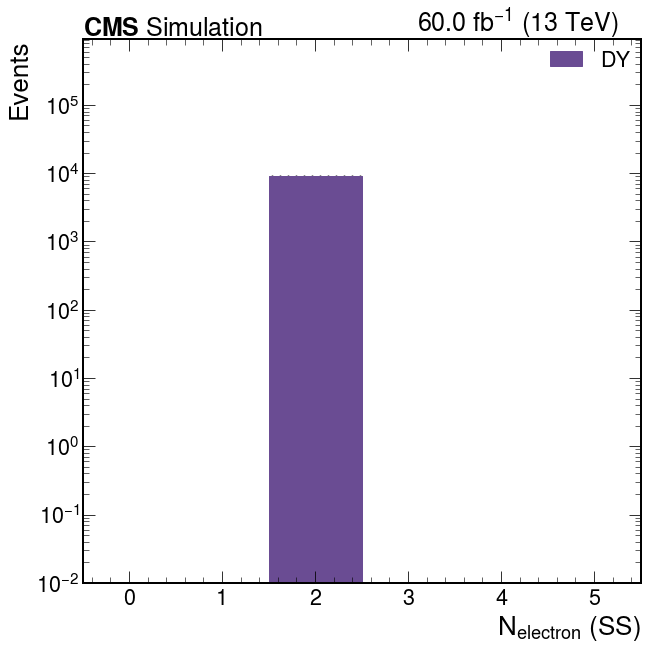

In [83]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping


my_hist = scale_and_merge(output['N_ele'], meta, fileset, nano_mapping)

# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}\ (SS)$',
         new_colors=my_colors, new_labels=my_labels,
         #order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_ele_truth'
        )


4595.180879101467
Data: 0 MC: 4595.18


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/N_ele_ratio


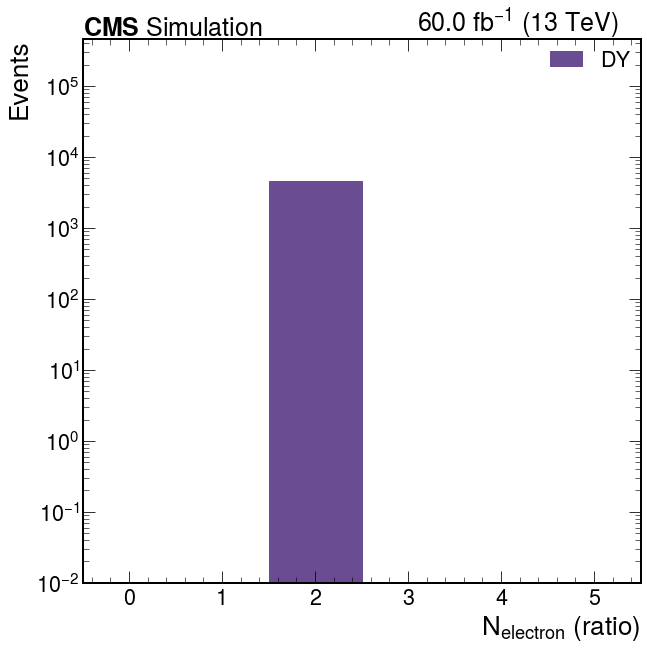

In [84]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping


my_hist = scale_and_merge(output['N_ele2'], meta, fileset, nano_mapping)

# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}\ (ratio)$',
         new_colors=my_colors, new_labels=my_labels,
         #order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_ele_ratio'
        )


9136.307079585133
Data: 0 MC: 9176.0


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/N_flips_truth


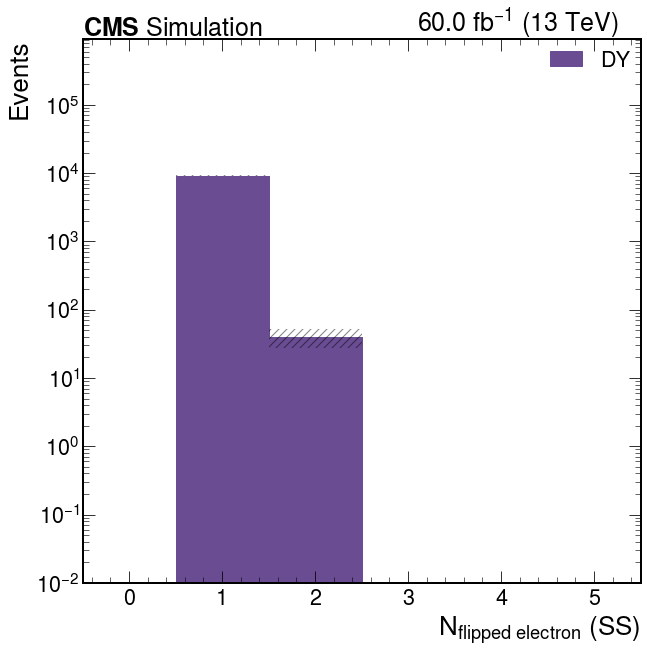

In [85]:
my_hist = scale_and_merge(output['electron_flips'], meta, fileset, nano_mapping)

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{flipped\ electron}\ (SS)$',
         new_colors=my_colors, new_labels=my_labels,
         #order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_flips_truth'
        )

4535.102129876998
Data: 0 MC: 4595.18


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/N_flips_ratio


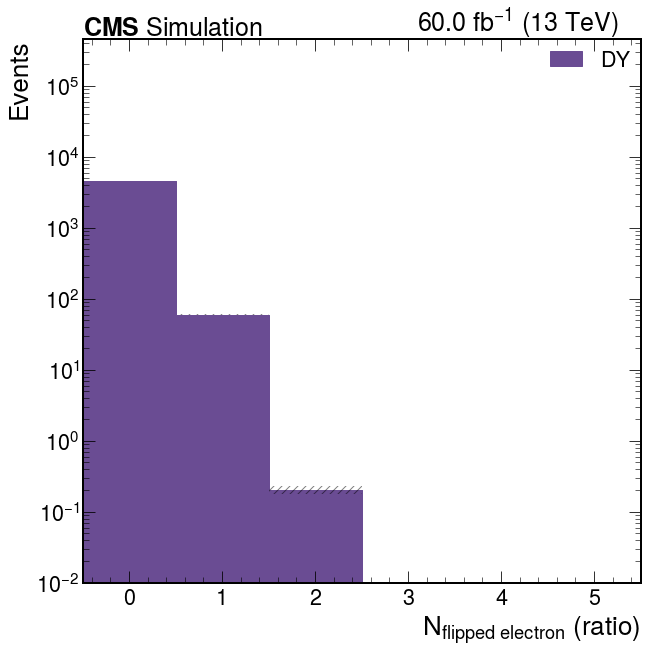

In [86]:
my_hist = scale_and_merge(output['electron_flips2'], meta, fileset, nano_mapping)

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{flipped\ electron}\ (ratio)$',
         new_colors=my_colors, new_labels=my_labels,
         #order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/N_flips_ratio'
        )

7332.213469048238
Data: 0 MC: 9176.0


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/pt_truth


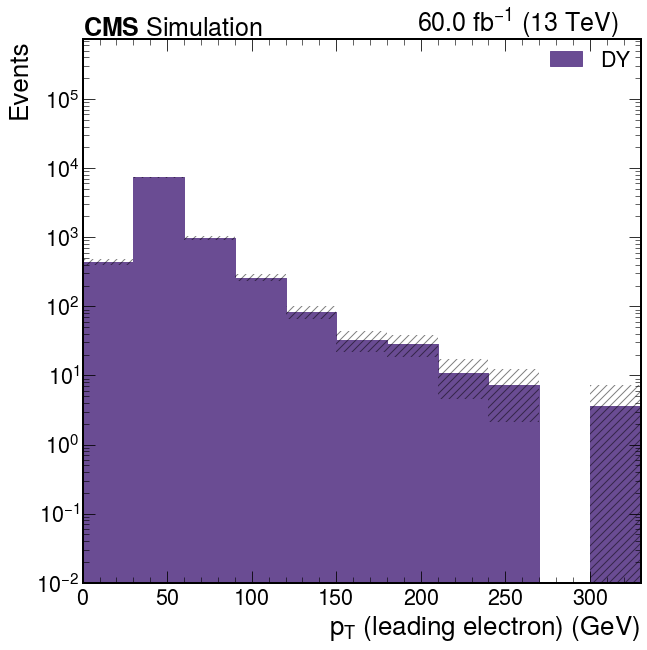

In [87]:
my_hist = scale_and_merge(output['electron'], meta, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (leading\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         #order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/pt_truth'
        )

3677.0152893820346
Data: 0 MC: 4595.18


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/pt_ratio


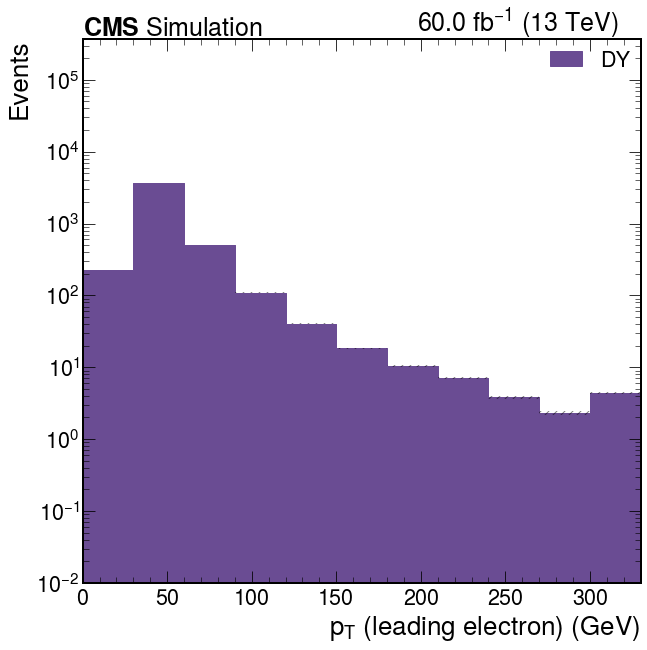

In [88]:
my_hist = scale_and_merge(output['electron2'], meta, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (leading\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         #order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/pt_ratio'
        )

3023.687306863274
Data: 0 MC: 9176.0


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/eta_truth


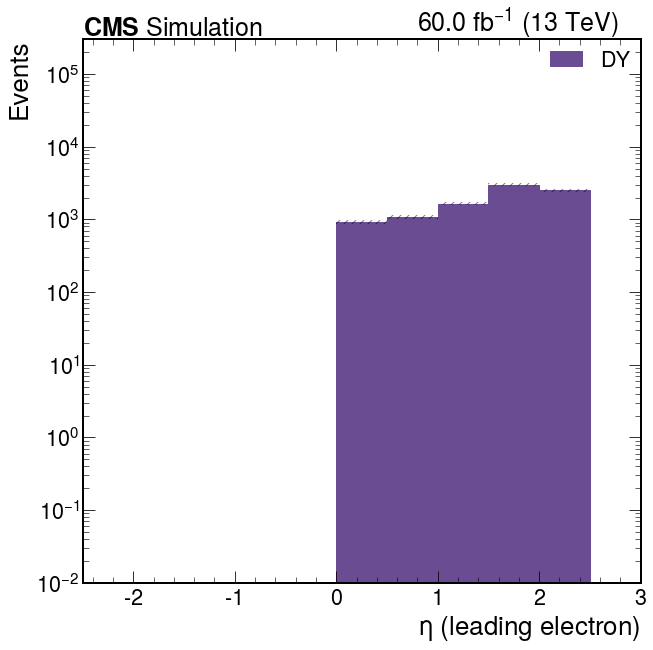

In [89]:
my_hist = scale_and_merge(output['electron'], meta, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (leading\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         #order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/eta_truth'
        )

1826.1326631009172
Data: 0 MC: 4595.18


Figure saved in: /home/users/ewallace/public_html/tW_scattering/histos/eta_ratio


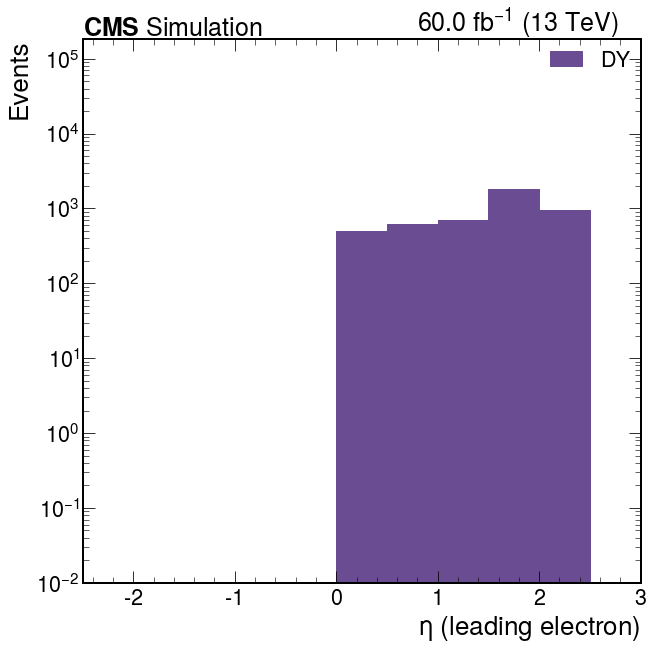

In [90]:
my_hist = scale_and_merge(output['electron2'], meta, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (leading\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         #order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
         save=os.path.expandvars(cfg['meta']['plots'])+'histos/eta_ratio'
        )